In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import scale
import warnings
from matplotlib.lines import Line2D
import geopandas as gpd
import matplotlib.colors as colors

PROJ: proj_create_from_database: Cannot find proj.db


# Import and format datasets

In [2]:
#Import the dataset for the full models (without refusal)
county_analysis_data = pd.read_csv('~/social_distancing_data.csv')

#Add the scaled variables to this dataframe
county_analysis_data['scaled_income'] = scale(county_analysis_data['median_household_income'])
county_analysis_data['scaled_poor'] = scale(county_analysis_data['prop_poor'])
county_analysis_data['scaled_pop_density'] = scale(county_analysis_data['pop_density_land'])
county_analysis_data['scaled_black'] = scale(county_analysis_data['black_prop'])
county_analysis_data['scaled_essential'] = scale(county_analysis_data['proportion_essential'])
county_analysis_data['scaled_prop_coverage'] = scale(county_analysis_data['prop_coverage'])

#Import the geodataframe for US counties 
#Can be downloaded from https://github.com/bansallab/SESdistancing/tree/master/US_counties
link = '~/US_counties/US_county_boundaries.shp'
gdf = gpd.read_file(link)

#Add the value for choropleth to gdf 
gdf['county_fips'] = gdf['CTFIPS'].astype(int)
gdf['state'] = gdf['STFIPS'].astype(int)
county_data_for_choropleth = county_analysis_data[['county_fips', 'mean_after_drop_dist']].copy() 
gdf = gdf.merge(county_data_for_choropleth, on = 'county_fips', how = 'left')

# Code for choropleth map

Uses the mean value in phase 3 of the "distance traveled" measure. 

Alaska and Hawaii are ignored even though data is available. 

C:\Users\romai\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


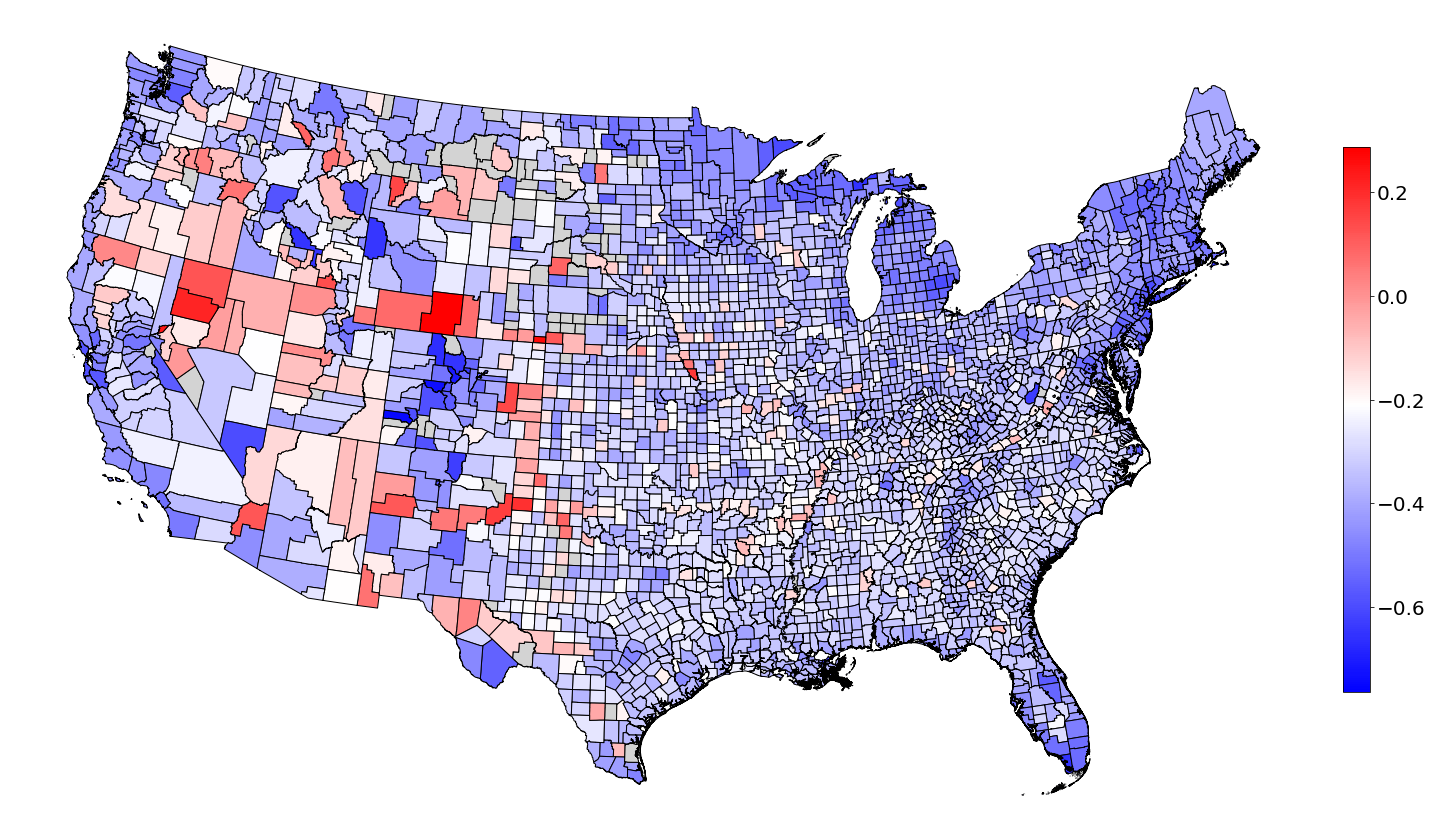

In [3]:
#Reproject to conic equal area
#Original gdf is in WGS84
#Note that it returns a future warning - might need changing at a later date
gdf_new_proj = gdf.to_crs('epsg:6350')

#Remove HI, PR, AK to limit the plot to CONUS
bad_states = [2, 15, 72]
gdf_for_plot = gdf_new_proj[~gdf_new_proj['state'].isin(bad_states)].copy()

#Get a gdf of NaNs and a gdf without them 
gdf_no_na = gdf_for_plot[~gdf_for_plot['mean_after_drop_dist'].isna()]
gdf_na = gdf_for_plot[gdf_for_plot['mean_after_drop_dist'].isna()]

#Set the figure format
fig = plt.figure(figsize = (20, 20))

#Add a single subplot
ax = fig.add_subplot(111)

#Set the normalization for the color map 
#Uses a diverging normalization, with the 90th percentile as the center point
divnorm = colors.DivergingNorm(vmin=np.min(gdf_no_na['mean_after_drop_dist']), vcenter = np.quantile(gdf_no_na['mean_after_drop_dist'], 0.9), vmax=np.max(gdf_no_na['mean_after_drop_dist']))

gdf_na.plot(facecolor = 'lightgrey', ax = ax, edgecolor = 'black') #plot counties with NaN in grey
gdf_no_na.plot(column = 'mean_after_drop_dist', cmap = 'bwr', norm = divnorm, ax = ax, edgecolor = 'black') #plot counties with value of distancing with cmap 
ax.axis('off')

# Create colorbar as a legend
sm_ax = plt.cm.ScalarMappable(cmap='bwr', norm=divnorm)
# empty array for the data range
sm_ax._A = []
# add the colorbar to the figure
cbar_ax = plt.colorbar(sm_ax, fraction=0.02, pad=0.017, ax = ax)
cbar_ax.ax.tick_params(labelsize=20)

#Get a clean layout
plt.tight_layout()

#Export the resulting map
plt.savefig('C:/Users/romai/Downloads/choropleth_social_distancing.png', dpi = 600)

# Statistical analysis - without refusal

### Models for the mean in phase 3

In [4]:
#Mixed model has a tendency to return warnings - filter them out 
warnings.filterwarnings('ignore')

#Filter the data for the visitation metric - mixed models doesn't accept NaNs
visit_data = county_analysis_data[county_analysis_data['mean_after_drop_visitation'].notnull()].copy()

#Feature of the model
list_features = ['scaled_prop_coverage', 
                 'scaled_poor', 
                 'scaled_pop_density', 
                 'scaled_black',
                 'scaled_essential']

features = ' + '.join(list_features) #Make an object based on the features

#List the targets
list_target = ['mean_after_drop_dist',
                   'mean_after_drop_visitation',
                   'mean_after_drop_encounters']

#Set up a dataframe that will be filled in with the model results
all_model_results = pd.DataFrame()

#Set up a separate dataframe that will be filled with information used for the coef plot
coef_df_phase3 = pd.DataFrame()

#Loop through targetz
for target in list_target:
    if 'visitation' in target: #Set up a mixed lm when visitation is the target
        model_lme = smf.mixedlm(target + '~' + features, visit_data, groups = visit_data['state_name'])
    
    else: #Set up a mixed lm for distance traveled and encounters rate
        model_lme = smf.mixedlm(target + '~' + features, county_analysis_data, groups = county_analysis_data['state_name'])
        
        
    model_lme_fit = model_lme.fit() #Fit the mixed lm
    err_series = model_lme_fit.params - model_lme_fit.conf_int()[0] #Extract the confidence interval for the coef plot

    variables = [var for var in model_lme_fit.pvalues.index] #Variable names
    pvals = [np.round(val, 3) for val in model_lme_fit.pvalues] #p-values
    tvals = [np.round(val, 3) for val in model_lme_fit.tvalues] #t-values

    #Dataframe of model results
    model_results = pd.DataFrame({'Variables': [var + '_' + target for var in variables], 'tvals' : tvals, 'pvals' : pvals})
    
    #Concatenate the df of model results to results for other targets
    all_model_results = pd.concat([all_model_results, model_results])
    
    #Dataframe of model coefficients
    coef_df_mod = pd.DataFrame({'coef': model_lme_fit.params.values[2:-1],
                            'err': err_series.values[2:-1],
                            'varname': err_series.index.values[2:-1],
                            'model' : target})
    
    #Concatenate to coefficients from other models
    coef_df_phase3 = pd.concat([coef_df_phase3, coef_df_mod])

#Rename the variablesa and the models for the coef plot
dict_names = {'scaled_poor' : 'Proportion below poverty level', 
                          'scaled_pop_density' : 'Population density', 
                          'scaled_black' : 'Proportion Black',
                          'scaled_essential' : 'Proportion of essential workers'}

dict_models = {'mean_after_drop_dist' : 'Distance traveled', 
              'mean_after_drop_visitation' : 'Visitation rate',
              'mean_after_drop_encounters' : 'Encounters rate'}

coef_df_phase3['varname'].replace(dict_names, inplace = True)
coef_df_phase3['model'].replace(dict_models, inplace = True)   

#Print the model results below
all_model_results

,Variables,tvals,pvals
0,Intercept_mean_after_drop_dist,-31.466,0.000
1,scaled_prop_coverage_mean_after_drop_dist,8.417,0.000
2,scaled_poor_mean_after_drop_dist,11.095,0.000
3,scaled_pop_density_mean_after_drop_dist,-9.853,0.000
4,scaled_black_mean_after_drop_dist,-3.147,0.002
5,scaled_essential_mean_after_drop_dist,6.191,0.000
6,Group Var_mean_after_drop_dist,4.339,0.000
0,Intercept_mean_after_drop_visitation,-52.768,0.000
1,scaled_prop_coverage_mean_after_drop_visitation,-1.485,0.137
2,scaled_poor_mean_after_drop_visitation,7.919,0.000


### Model for the slope in phase 2

In [5]:
#Same methodology as above
warnings.filterwarnings('ignore')

visit_data = county_analysis_data[county_analysis_data['mean_after_drop_visitation'].notnull()].copy()

list_features = ['scaled_prop_coverage', 
                 'scaled_poor', 
                 'scaled_pop_density', 
                 'scaled_black',
                 'scaled_essential']

features = ' + '.join(list_features)

list_target = [    'slope_drop_dist',
                   'slope_drop_visitation',
                   'slope_drop_encounters']

all_model_results = pd.DataFrame()
coef_df_phase2 = pd.DataFrame() 

for target in list_target:
    if 'visitation' in target: 
        model_lme = smf.mixedlm(target + '~' + features, visit_data, groups = visit_data['state_name'])
    
    else: 
        model_lme = smf.mixedlm(target + '~' + features, county_analysis_data, groups = county_analysis_data['state_name'])
        
        
    model_lme_fit = model_lme.fit() 
    err_series = model_lme_fit.params - model_lme_fit.conf_int()[0]
    
    variables = [var for var in model_lme_fit.pvalues.index]
    pvals = [np.round(val, 3) for val in model_lme_fit.pvalues]
    tvals = [np.round(val, 3) for val in model_lme_fit.tvalues]

    model_results = pd.DataFrame({'Variables': [var + '_' + target for var in variables], 'tvals' : tvals, 'pvals' : pvals})
    
    all_model_results = pd.concat([all_model_results, model_results])
    
    coef_df_mod = pd.DataFrame({'coef': model_lme_fit.params.values[2:-1],
                            'err': err_series.values[2:-1],
                            'varname': err_series.index.values[2:-1],
                            'model' : target})
    coef_df_phase2 = pd.concat([coef_df_phase2, coef_df_mod])

dict_names = {'scaled_poor' : 'Proportion below poverty level', 
                          'scaled_pop_density' : 'Population density', 
                          'scaled_black' : 'Proportion Black',
                          'scaled_essential' : 'Proportion of essential workers'}

dict_models = {'mean_after_drop_dist' : 'Distance traveled', 
              'mean_after_drop_visitation' : 'Visitation rate',
              'mean_after_drop_encounters' : 'Encounters rate'}

coef_df_phase2['varname'].replace(dict_names, inplace = True)
coef_df_phase2['model'].replace(dict_models, inplace = True)

all_model_results

,Variables,tvals,pvals
0,Intercept_slope_drop_dist,-19.572,0.000
1,scaled_prop_coverage_slope_drop_dist,2.639,0.008
2,scaled_poor_slope_drop_dist,16.069,0.000
3,scaled_pop_density_slope_drop_dist,-16.002,0.000
4,scaled_black_slope_drop_dist,-4.479,0.000
5,scaled_essential_slope_drop_dist,6.047,0.000
6,Group Var_slope_drop_dist,3.708,0.000
0,Intercept_slope_drop_visitation,-28.154,0.000
1,scaled_prop_coverage_slope_drop_visitation,-4.610,0.000
2,scaled_poor_slope_drop_visitation,10.223,0.000


### Models for the slope in phase 4

In [6]:
#Same methodology as above
warnings.filterwarnings('ignore')

visit_data = county_analysis_data[county_analysis_data['mean_after_drop_visitation'].notnull()].copy()

list_features = ['scaled_prop_coverage', 
                 'scaled_poor', 
                 'scaled_pop_density', 
                 'scaled_black',
                 'scaled_essential']

features = ' + '.join(list_features)

list_target = ['slope_last_fatigue_dist',
               'slope_last_fatigue_visitation', 
               'slope_last_fatigue_encounters']

all_model_results = pd.DataFrame()
coef_df_phase4 = pd.DataFrame()

for target in list_target:
    if 'visitation' in target: 
        df = visit_data[visit_data['series_fatigue_visitation'] == 1].copy()
            
    elif 'dist' in target: 
        df = county_analysis_data[county_analysis_data['series_fatigue_dist'] == 1].copy()
    
    else: 
        df = county_analysis_data[county_analysis_data['series_fatigue_encounters'] == 1].copy()
        
    model_lme = smf.mixedlm(target + '~' + features, df, groups = df['state_name'])  
    model_lme_fit = model_lme.fit() 
    err_series = model_lme_fit.params - model_lme_fit.conf_int()[0]

    variables = [var for var in model_lme_fit.pvalues.index]
    pvals = [np.round(val, 3) for val in model_lme_fit.pvalues]
    tvals = [np.round(val, 3) for val in model_lme_fit.tvalues]

    model_results = pd.DataFrame({'Variables': [var + '_' + target for var in variables], 'tvals' : tvals, 'pvals' : pvals})
    
    all_model_results = pd.concat([all_model_results, model_results])
    
    coef_df_mod = pd.DataFrame({'coef': model_lme_fit.params.values[2:-1],
                            'err': err_series.values[2:-1],
                            'varname': err_series.index.values[2:-1],
                            'model' : target})
    coef_df_phase4 = pd.concat([coef_df_phase4, coef_df_mod])

dict_names = {'scaled_poor' : 'Proportion below poverty level', 
                          'scaled_pop_density' : 'Population density', 
                          'scaled_black' : 'Proportion Black',
                          'scaled_essential' : 'Proportion of essential workers'}

dict_models = {'mean_after_drop_dist' : 'Distance traveled', 
              'mean_after_drop_visitation' : 'Visitation rate',
              'mean_after_drop_encounters' : 'Encounters rate'}

coef_df_phase4['varname'].replace(dict_names, inplace = True)
coef_df_phase4['model'].replace(dict_models, inplace = True)

all_model_results

,Variables,tvals,pvals
0,Intercept_slope_last_fatigue_dist,39.901,0.000
1,scaled_prop_coverage_slope_last_fatigue_dist,1.308,0.191
2,scaled_poor_slope_last_fatigue_dist,6.649,0.000
3,scaled_pop_density_slope_last_fatigue_dist,-3.980,0.000
4,scaled_black_slope_last_fatigue_dist,-3.611,0.000
5,scaled_essential_slope_last_fatigue_dist,-4.778,0.000
6,Group Var_slope_last_fatigue_dist,4.279,0.000
0,Intercept_slope_last_fatigue_visitation,27.910,0.000
1,scaled_prop_coverage_slope_last_fatigue_visita...,7.853,0.000
2,scaled_poor_slope_last_fatigue_visitation,2.604,0.009


# Coefficient plot for all the models

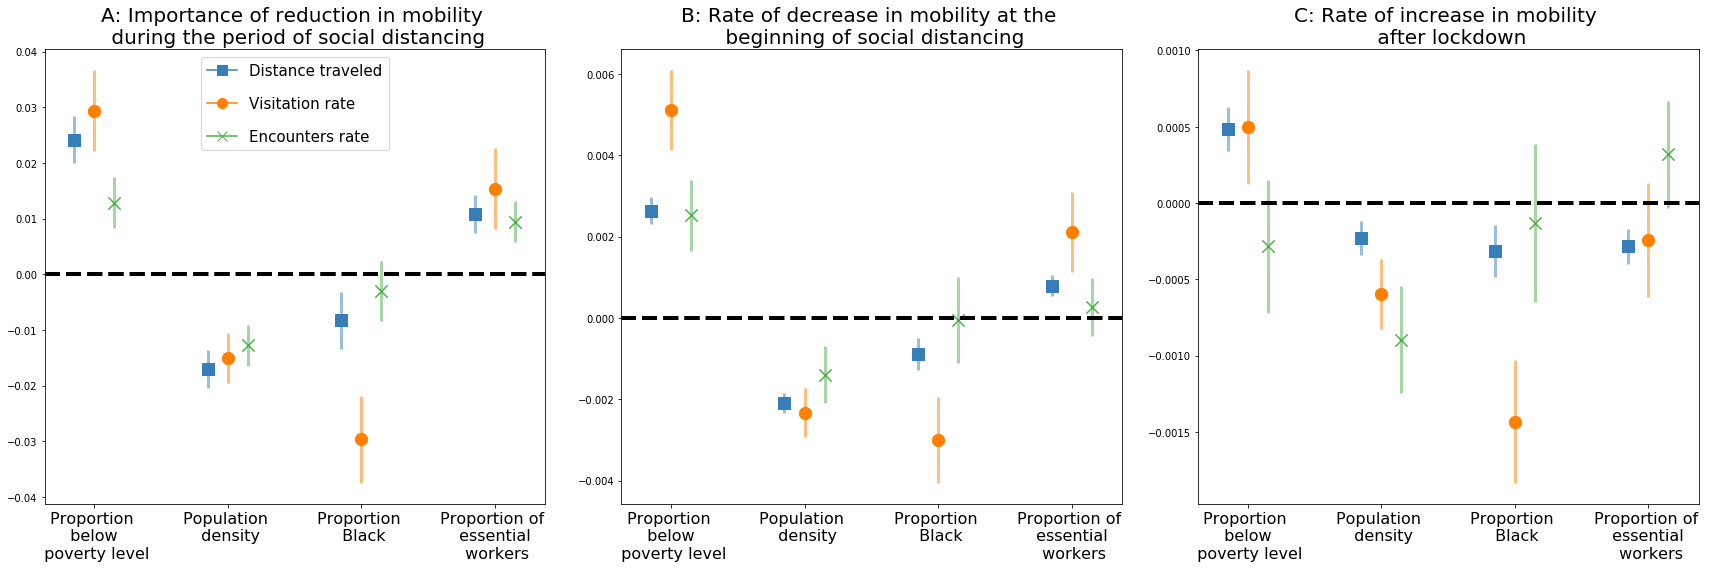

In [7]:
## list of markers to use
marker_list = 'sox'

#Space between the bars
width=0.15

#Colors to use for the bars
color_palette = ['#377eb8', '#ff7f00', '#4daf4a']

# Set the x locations for the different bars in the plot
# 4 covariates in total
base_x = np.arange(4) - width

#Set the figure format and the subplots - one for each model
fig = plt.figure(figsize=(24, 8))
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

##### First panel #####
#Loop through the models for the first plot (phase ii)
for i, mod in enumerate(coef_df_phase3.model.unique()):
    mod_df = coef_df_phase3[coef_df_phase3.model == mod]
    varnames = mod_df['varname']
    mod_df = mod_df.set_index('varname').reindex(coef_df_phase3['varname'].unique())
    ## offset x posistions
    X = base_x + width*i 
    # Plot the vertical error bars
    # With a zorder of 1 (behind the marker)
    # And alpha = 0.5 to add some transparency
    ax1.vlines(X, ymin = mod_df['coef'] - mod_df['err'],ymax = mod_df['coef'] + mod_df['err'], linewidth = 3, zorder = 1, 
              color = color_palette[i], alpha = 0.5)
    ## remove axis labels
    ax1.set_ylabel('')
    ax1.set_xlabel('')
    #Plot the markers 
    #zorder = 2 ensures they show on top of the vertical bars
    ax1.scatter(x=X, 
               marker=marker_list[i], s=150, 
               y=mod_df['coef'], color=color_palette[i], zorder = 2) 
    #Add an horizontal line at 0 to easily read the significance 
    ax1.axhline(y=0, linestyle='--', color='black', linewidth=4)
    #Add the x ticks - centered on the middle marker
    ax1.set_xticks(np.arange(4))
    #Add the labels
    ax1.set_xticklabels(['Proportion \n below \n poverty level', 
                         'Population \n density', 
                         'Proportion \n Black', 
                         'Proportion of \n essential \n workers'], 
                           rotation=0, fontsize=16)

#Build a customized legend
#Only show on the first subplot - same in the other ones
mod_list = coef_df_phase3['model'].unique()
legend_elements = [Line2D([0], [0], marker=m,
                          label=mod_list[i],
                          color = color_palette[i],
                          markersize=10)
                   for i, m in enumerate(marker_list)
                  ]
ax1.legend(handles=legend_elements, loc='upper center', 
              prop={'size': 15}, labelspacing=1.2)
#Add a plot title
ax1.set_title('A: Importance of reduction in mobility \n during the period of social distancing', size = 20)

#### Second Panel #### 
# See first panel for annotated code
# Note that there is no legend
for i, mod in enumerate(coef_df_phase2.model.unique()):
    mod_df = coef_df_phase2[coef_df_phase2.model == mod]
    varnames = mod_df['varname']
    mod_df = mod_df.set_index('varname').reindex(coef_df_phase2['varname'].unique())
    X = base_x + width*i
    ax2.vlines(X, ymin = mod_df['coef'] - mod_df['err'],ymax = mod_df['coef'] + mod_df['err'], linewidth = 3, zorder = 1,
              color = color_palette[i], alpha = 0.5)
    ax2.set_ylabel('')
    ax2.set_xlabel('')
    ax2.scatter(x=X, 
               marker=marker_list[i], s=150, 
               y=mod_df['coef'], color=color_palette[i], zorder = 2)
    ax2.axhline(y=0, linestyle='--', color='black', linewidth=4)
    ax2.set_xticks(np.arange(4))
    ax2.set_xticklabels(['Proportion \n below \n poverty level', 
                         'Population \n density', 
                         'Proportion \n Black', 
                         'Proportion of \n essential \n workers'], 
                           rotation=0, fontsize=16)

ax2.set_title('B: Rate of decrease in mobility at the \n beginning of social distancing', size = 20)

#### Third Panel #### 
# See first panel for annotated code
# Note that there is no legend
for i, mod in enumerate(coef_df_phase4.model.unique()):
    mod_df = coef_df_phase4[coef_df_phase4.model == mod]
    varnames = mod_df['varname']
    mod_df = mod_df.set_index('varname').reindex(coef_df_phase4['varname'].unique())
    ## offset x posistions
    X = base_x + width*i
    ax3.vlines(X, ymin = mod_df['coef'] - mod_df['err'],ymax = mod_df['coef'] + mod_df['err'], linewidth = 3, zorder = 1, 
              color = color_palette[i], alpha = 0.5)
    ## remove axis labels
    ax3.set_ylabel('')
    ax3.set_xlabel('')
    ax3.scatter(x=X, 
               marker=marker_list[i], s=150, 
               y=mod_df['coef'], color=color_palette[i], zorder = 2)
    ax3.axhline(y=0, linestyle='--', color='black', linewidth=4)
    ax3.set_xticks(np.arange(4))
    ax3.set_xticklabels(['Proportion \n below \n poverty level',
                         'Population \n density', 
                         'Proportion \n Black', 
                         'Proportion of \n essential \n workers'], 
                           rotation=0, fontsize=16)
    
ax3.set_title('C: Rate of increase in mobility \n after lockdown', size = 20)

#Get a clean layout
plt.tight_layout() 

#Export the figure in high resolution 
plt.savefig('C:/Users/romai/Downloads/coef_plot_paper.png', dpi = 600)

# Supplementary analyses with interactions

We include three interactions: 

-poverty status and race

-poverty status and essential status 

-essential status and race

In [8]:
#Mixed model has a tendency to return warnings - filter them out 
warnings.filterwarnings('ignore')

#Filter the data for the visitation metric - mixed models doesn't accept NaNs
visit_data = county_analysis_data[county_analysis_data['mean_after_drop_visitation'].notnull()].copy()

#Feature of the model
list_features = ['scaled_prop_coverage', 
                 'scaled_poor', 
                 'scaled_pop_density', 
                 'scaled_black',
                 'scaled_essential',
                 'scaled_essential:scaled_poor', 
                 'scaled_essential:scaled_black',
                 'scaled_poor:scaled_black']

features = ' + '.join(list_features) #Make an object based on the features

#List the targets
target = 'mean_after_drop_dist'

model_lme = smf.mixedlm(target + '~' + features, county_analysis_data, groups = county_analysis_data['state_name'])
        
        
model_lme_fit = model_lme.fit() #Fit the mixed lm

model_lme_fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:               MixedLM   Dependent Variable:   mean_after_drop_dist
No. Observations:    3054      Method:               REML                
No. Groups:          51        Scale:                0.0081              
Min. group size:     1         Log-Likelihood:       2888.0772           
Max. group size:     244       Converged:            Yes                 
Mean group size:     59.9                                                
-------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                     -0.341    0.011 -31.410 0.000 -0.362 -0.319
scaled_prop_coverage           0.018    0.002   8.396 0.000  0.014  0.022
scaled_poor                    0.024    0.002  11.129 0.000  0.020  0.029
scaled_pop_density            -0.017    0.002  -9.691 0.000 -0.020 -0.013
scaled_black                  -0.013    0.003  -4.019 0.000 -0.020 -0.007
scaled_essential               0.014    0.002   7.589 0.000  0.010  0.017
scaled_essential:scaled_poor  -0.009    0.002  -6.081 0.000 -0.012 -0.006
scaled_essential:scaled_black  0.005    0.002   3.321 0.001  0.002  0.008
scaled_poor:scaled_black       0.003    0.001   1.845 0.065 -0.000  0.005
Group Var                      0.006    0.014                            
=========================================================================

"""